# Task 1: Preprocess and Explore the Data

## Objective
Load, clean, and understand the historical financial data for TSLA, BND, and SPY. This analysis will inform our modeling decisions in the next tasks.

### Assets
- **TSLA (Tesla)**: High-growth stock, high risk.
- **BND (Vanguard Total Bond Market ETF)**: Bond market tracking, low risk, stability.
- **SPY (S&P 500 ETF)**: Broad market exposure, moderate risk.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set plot style
sns.set_theme(style="whitegrid")

## 1. Load and Clean the Data

The initial inspection showed that the CSVs have a "triple header" (Ticker name and empty Date labels in the first few rows). We need to filter those out and ensure numeric types.

In [9]:
data_path = "../data/processed"
assets = ["TSLA", "BND", "SPY"]

def load_and_clean(ticker, path):
    file_path = os.path.join(path, f"{ticker}_historical_data.csv")
    # Load data
    df = pd.read_csv(file_path)
    
    # 1. Filter out irrelevant records (redundant header rows)
    if 'Price' in df.columns:
        df = df[~df['Price'].isin(['Ticker', 'Date'])].copy()
        df.rename(columns={'Price': 'Date'}, inplace=True)
    
    # 2. Verify and convert data types
    df['Date'] = pd.to_datetime(df['Date'])
    for col in ['Close', 'High', 'Low', 'Open', 'Volume']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 3. Remove duplicate records
    df = df.drop_duplicates(subset=['Date'])
    
    # 4. Handle missing values (Interpolate then remove remaining)
    df = df.sort_values('Date')
    df = df.interpolate(method='linear')
    df.dropna(inplace=True)
    
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    return df

dfs = {asset: load_and_clean(asset, data_path) for asset in assets}

for asset, df in dfs.items():
    print(f"{asset} loaded and cleaned. Shape: {df.shape}")

TSLA loaded and cleaned. Shape: (2775, 5)
BND loaded and cleaned. Shape: (2775, 5)
SPY loaded and cleaned. Shape: (2775, 5)


## 2. Basic Inspection (Post-Cleaning)

In [10]:
for asset, df in dfs.items():
    print(f"\n--- {asset} Statistics ---")
    display(df.describe())


--- TSLA Statistics ---


,Close,High,Low,Open,Volume
count,2775.000000,2775.000000,2775.000000,2775.000000,2.775000e+03
mean,138.472937,141.534064,135.271181,138.505925,1.108480e+08
std,131.682073,134.616345,128.668762,131.791350,7.145365e+07
min,9.578000,10.331333,9.403333,9.488000,1.062000e+07
25%,17.851666,18.087000,17.588000,17.836666,6.758150e+07
50%,91.625999,94.484001,89.113998,93.066666,9.264600e+07
75%,242.028336,247.846664,236.978333,242.901665,1.282366e+08
max,489.880005,498.829987,485.329987,489.880005,9.140820e+08



--- BND Statistics ---


,Close,High,Low,Open,Volume
count,2775.000000,2775.000000,2775.000000,2775.000000,2.775000e+03
mean,67.325728,67.424459,67.224864,67.328206,4.485148e+06
std,4.685294,4.692171,4.676260,4.685213,2.918896e+06
min,59.698631,59.772439,59.661729,59.728157,0.000000e+00
25%,63.436426,63.504392,63.370278,63.438516,2.172700e+06
50%,66.492111,66.634788,66.376242,66.478968,4.175700e+06
75%,71.237354,71.377835,71.094423,71.256967,6.043050e+06
max,76.068130,76.161647,76.034125,76.127648,3.396300e+07



--- SPY Statistics ---


,Close,High,Low,Open,Volume
count,2775.000000,2775.000000,2775.000000,2775.000000,2.775000e+03
mean,339.074724,340.845874,337.015720,339.015876,8.604954e+07
std,141.925745,142.569517,141.139477,141.905190,4.386106e+07
min,154.980881,156.031833,152.881578,154.540157,2.027000e+07
25%,219.599663,221.038702,218.370034,219.349115,5.881420e+07
50%,301.538483,303.765169,299.861332,302.125017,7.570750e+07
75%,423.938461,425.885996,421.455155,423.759636,9.923995e+07
max,695.159973,696.090027,691.349976,695.489990,5.072443e+08


## 3. Exploratory Data Analysis (Visual Analysis)

### 3.1 Closing Price Trends
Visualizing the closing price over time to identify long-term trends.

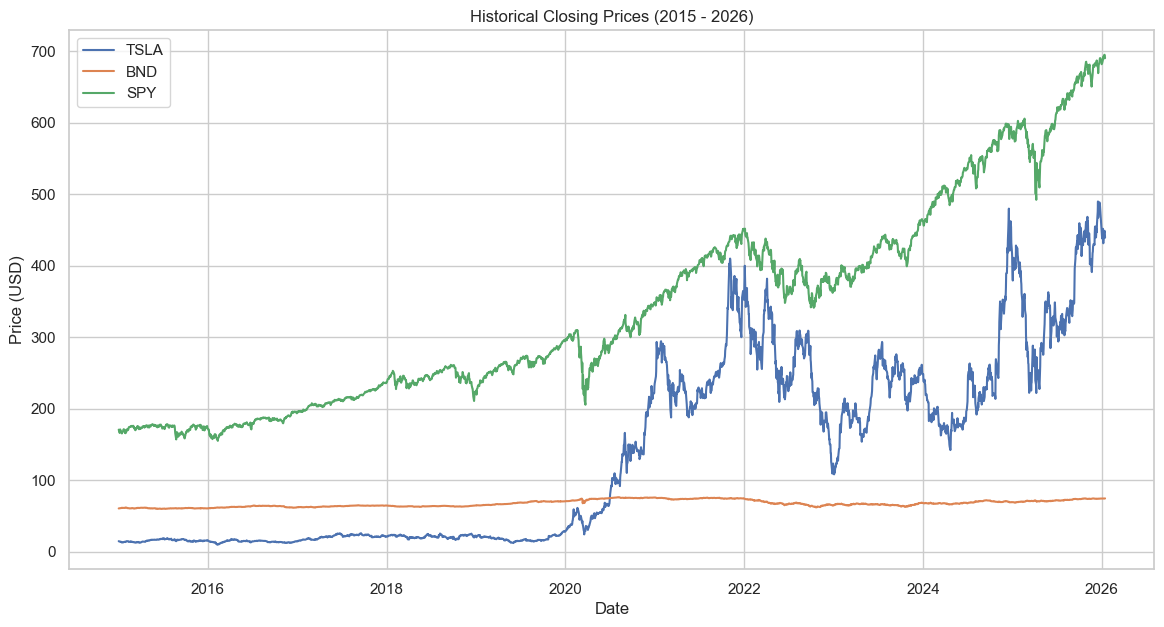

In [11]:
plt.figure(figsize=(14, 7))
for asset in assets:
    plt.plot(dfs[asset].index, dfs[asset]['Close'], label=asset)

plt.title('Historical Closing Prices (2015 - 2026)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

### 3.2 Daily Percentage Change (Volatility)
Calculated as: `(Close_t / Close_t-1) - 1`. This helps us observe the frequency and magnitude of price swings.

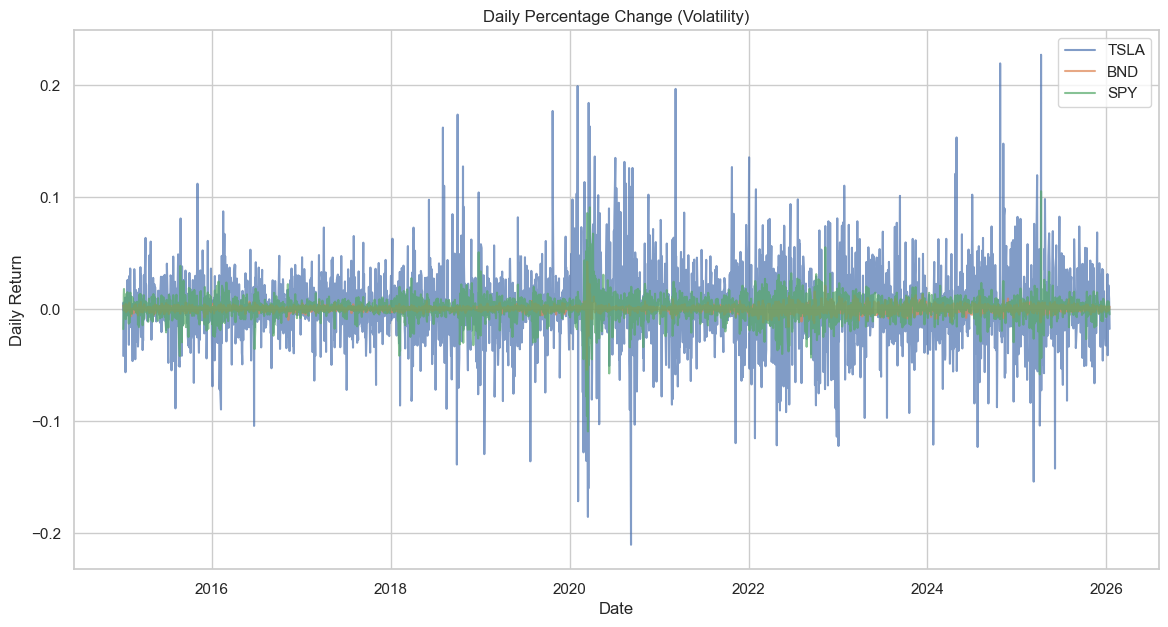

In [12]:
for asset in assets:
    dfs[asset]['Daily_Return'] = dfs[asset]['Close'].pct_change()

plt.figure(figsize=(14, 7))
for asset in assets:
    plt.plot(dfs[asset].index, dfs[asset]['Daily_Return'], label=asset, alpha=0.7)

plt.title('Daily Percentage Change (Volatility)')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

### 3.3 Rolling Statistics
Analyzing volatility by calculating rolling means (SMA) and rolling standard deviations (risk).

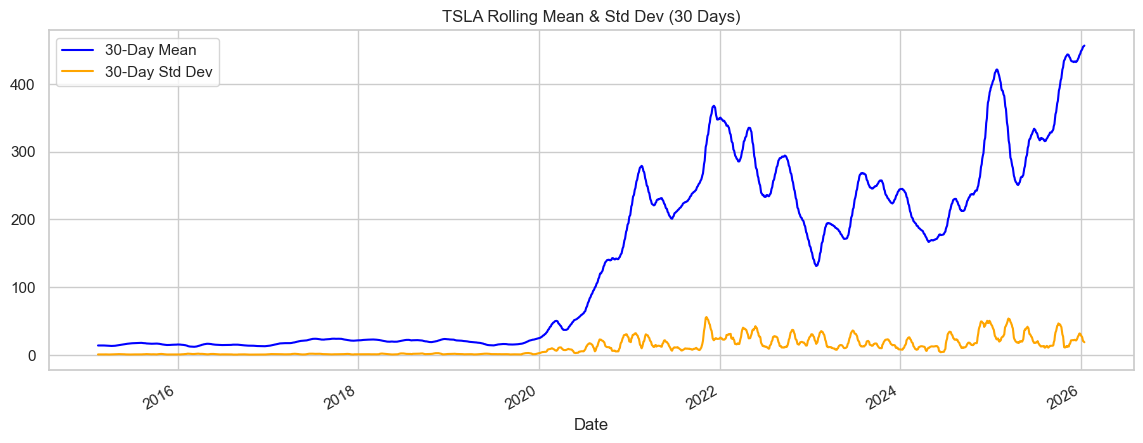

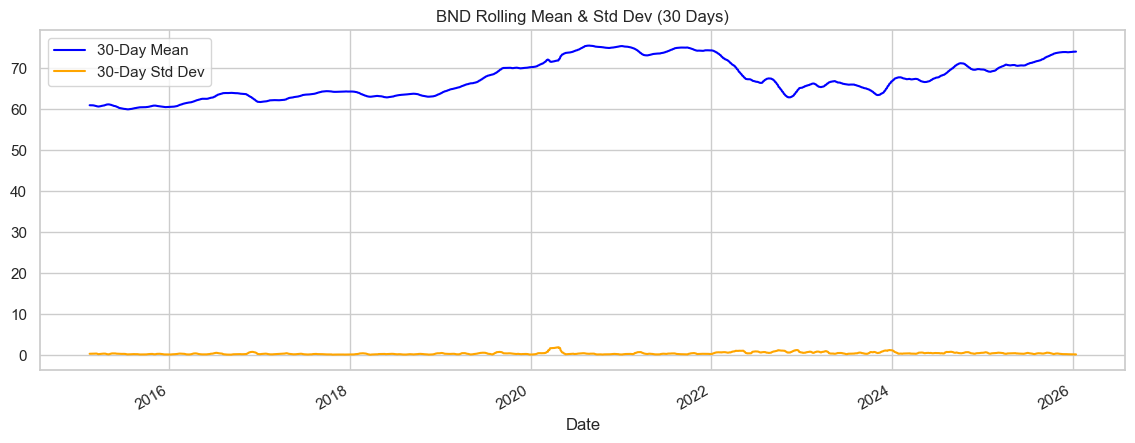

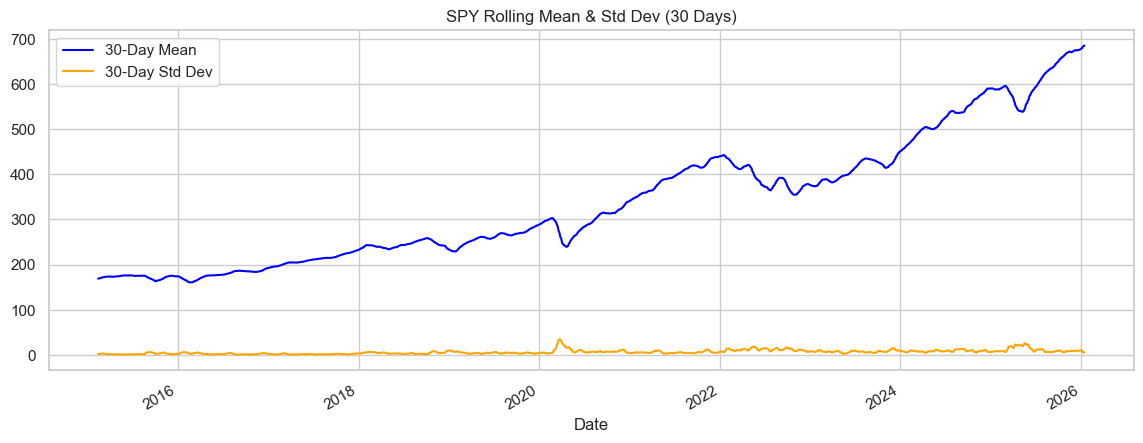

In [13]:
window = 30 # 30-day rolling window

for asset in assets:
    plt.figure(figsize=(14, 5))
    dfs[asset]['Close'].rolling(window=window).mean().plot(label=f'{window}-Day Mean', color='blue')
    dfs[asset]['Close'].rolling(window=window).std().plot(label=f'{window}-Day Std Dev', color='orange')
    plt.title(f'{asset} Rolling Mean & Std Dev ({window} Days)')
    plt.legend()
    plt.show()

### 3.4 Outlier Analysis
Detecting days with unusually high or low returns.

In [14]:
for asset in assets:
    # Define outlier as > 3 std devs from the mean
    mean_ret = dfs[asset]['Daily_Return'].mean()
    std_ret = dfs[asset]['Daily_Return'].std()
    outliers = dfs[asset][(dfs[asset]['Daily_Return'] > mean_ret + 3*std_ret) | 
                          (dfs[asset]['Daily_Return'] < mean_ret - 3*std_ret)]
    
    print(f"\n--- {asset} Outlier Days ({len(outliers)}) ---")
    display(outliers[['Close', 'Daily_Return']].head())


--- TSLA Outlier Days (44) ---


,Close,Daily_Return
Date,,
2015-11-04,15.442000,0.111735
2018-08-02,23.302668,0.161880
2018-09-28,17.651333,-0.139015
2018-10-01,20.713333,0.173471
2018-10-23,19.609333,0.127189



--- BND Outlier Days (32) ---


,Close,Daily_Return
Date,,
2020-03-10,72.896523,-0.013444
2020-03-11,71.515892,-0.018940
2020-03-12,67.626488,-0.054385
2020-03-13,70.480392,0.042201
2020-03-16,71.221207,0.010511



--- SPY Outlier Days (39) ---


,Close,Daily_Return
Date,,
2015-08-24,158.832565,-0.042107
2015-08-26,162.989899,0.038394
2016-06-24,174.042526,-0.035909
2018-02-05,232.936539,-0.041823
2018-02-08,227.376373,-0.037509
